# XGBoost Model

## Introduction

XGBoost is an ensemble learning method which is based on a collection of ensemble tree models. Aggregate the predictions from either a group of classifiers, or regressors. In this example I have chosen to classify the results from the 'Telco Customer Churn' dataset providing a Boolean result of True or False with respect to Churn.

The model is trained on a group of Decision Tree Classifiers first, with each classifier being trained on a random subset of the overall training data set. Then the predictions from all individual trees are then aggregated to predict the overall class that gets the most votes.

In terms of the sequence of events, XGBoost is normally applied at the last stage of a prediction or classification model. The other prediction/classification models are all aggregated to predict the prediction/class with the most votes - known as a 'hard voting predictor/classifier'.

This is all achieved using a series of 'boosting', 'bagging' and 'stacking' applications but first, I need to import the necessary libraries.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost
# I need to cross-validate and evaluate results
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

## Exploratory Data Analysis

What is apparent about the data at first glance? How can I shape the data? Can I perform dimensionality reduction? Can I perform feature engineering to improve the data quality? What relationships and insights can I gain from the information and does it require cleaning, re-scaling or pre-processing of any sort?

Which are the columns to be used in the feature subset and target column? At this stage I know that the 'Churn' column will be my target vector, but the predictor feature subset may require some work so it's best to try and understand each and every one of these columns in their entirety.

### Summarize the Data

I extracted this dataset from the Kaggle web site. In the Dataset option in the index menu on the left hand side I am provided with a Search option. Requesting 'Telco-Customer-Churn' using search, provides me with a list of options ranked according to 'Hotness' which is some measure of popularity. So the data sources on this page are all in flat file format such as XLSX or CSV which makes it easier to read the tabular structured data into Pandas, or a SQL DBMS.

I have decided to check a couple of variations of this IBM Telco Customer Churn dataset; the file provided by 'BlastChar' entitled 'Telco Customer Churn' and that of 'Jack Chang' entitled 'Telco customer churn (11.1.3+)'. Taking a look at any differences I have to decide which file would be more suitable for the purpose of this classification algorithm and where I can find the most comprehensive information summarizing the dataset? The reason I like using Kaggle is because they categorize their datasets according to popularity

Understanding how churn works is key to this project. It is a measure of whether or not customers are leaving, (the rate of loss, the attrition rate) or their dropout rate compared to the entire set of customers. This particular dataset is based on a fictional telecom company but discovering the rate of churn in general can be extremely useful if it's compared to that of other companies within the same industry. It can be used as a tool to monitor fluctuating consumer tastes and the effectiveness of competing companies. Ultimately the churn rate can be used to try and retain customers by predicting their behaviour.

List of Columns in 'BlastChar' CSV file:
 - customerID
 - gender
 - SeniorCitizen
 - Partner
 - Dependents
 - tenure
 - PhoneService
 - MultipleLines
 - InternetService
 - OnlineSecurity
 - OnlineBackup
 - DeviceProtection
 - TechSupport
 - StreamingTV
 - StreamingMovies
 - Contract
 - PaperlessBilling
 - PaymentMethod
 - MonthlyCharges
 - TotalCharges
 - Churn
 
 List of Columns in 'Jack Chang' XLSX file:
 - CustomerID
 - Count
 - Country
 - State
 - City
 - Zip Code
 - Lat Long
 - Latitude
 - Longitude
 - Gender
 - Senior Citizen
 - Partner
 - Dependents
 - Tenure Months
 - Phone Service
 - Multiple Lines
 - Internet Service
 - Online Security
 - Online Backup
 - Device Protection
 - Tech Support
 - Streaming TV
 - Streaming Movies
 - Contract
 - Paperless Billing
 - Payment Method
 - Monthly Charges
 - Total Charges
 - Churn Label
 - Churn Value
 - Churn Score
 - CLTV
 - Churn Reason
 
The 'BlastChar' list of columns is much shorter indicating some of the data has been pre-processed already. Let's see which columns might have been removed from the 'BlastChar' dataset and why? 'Count' is the first column which contains the value '1' in every single instance. This merely just counts the entry for that particular row and is of no significance to the table.
 
'Country' is the next column. These entries are all the same with the value: 'United States'. Again, this information carries no real value if all rows are identical.
 
'State' contains identical values: 'California'. Again, this doesn't add any value to our dataset.

'City' does actually contain a lot of different values.

In [7]:
telco_churn = pd.read_csv("C:/Users/lynst/Documents/Datasets/Kaggle/Jack Chang/telco_churn.csv")
telco_churn.head()

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,...,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,...,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,...,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,86,5372,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,...,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,84,5003,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,...,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1,89,5340,Competitor had better devices


In [10]:
City = telco_churn["City"]
City.unique()

array(['Los Angeles', 'Beverly Hills', 'Huntington Park', ..., 'Standish',
       'Tulelake', 'Olympic Valley'], dtype=object)

Having assessed both the files I have decided to use the source file provided by

## Import the Dataset

Read the data in using Pandas having selected the source and perform some EDA before cleaning or pre-processing.

In [2]:
# Start by importing a Classification dataset and defining my X and y values
df = pd.read_csv("C:/Users/lynst/Documents/Datasets/Kaggle/BlastChar/Telco-Customer-Churn.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


There are 21 columns but how many rows are there?

In [3]:
df.shape

(7043, 21)

This gives me the total number of instances (or rows) and columns. To list the names of the columns and their data type:

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


### Explore the Dataset

Exploring the dataset further I can produce a summary of mean values and their variance.

In [5]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


So immediately I realize that this 'describe( )' method will only summarize numeric data. I need to figure out which columns to use and whether or not the data can be converted into numeric values to improve the data quality and provide a more comprehensive prediction subset. Currently there are only 3 columns with numeric data which means I am limited in terms of the number of mathematical operations I can perform.

## Visualizing the Data

A visual summary of the dispersion of data about its mean using matplotlib.

array([[<Axes: title={'center': 'SeniorCitizen'}>,
        <Axes: title={'center': 'tenure'}>],
       [<Axes: title={'center': 'MonthlyCharges'}>, <Axes: >]],
      dtype=object)

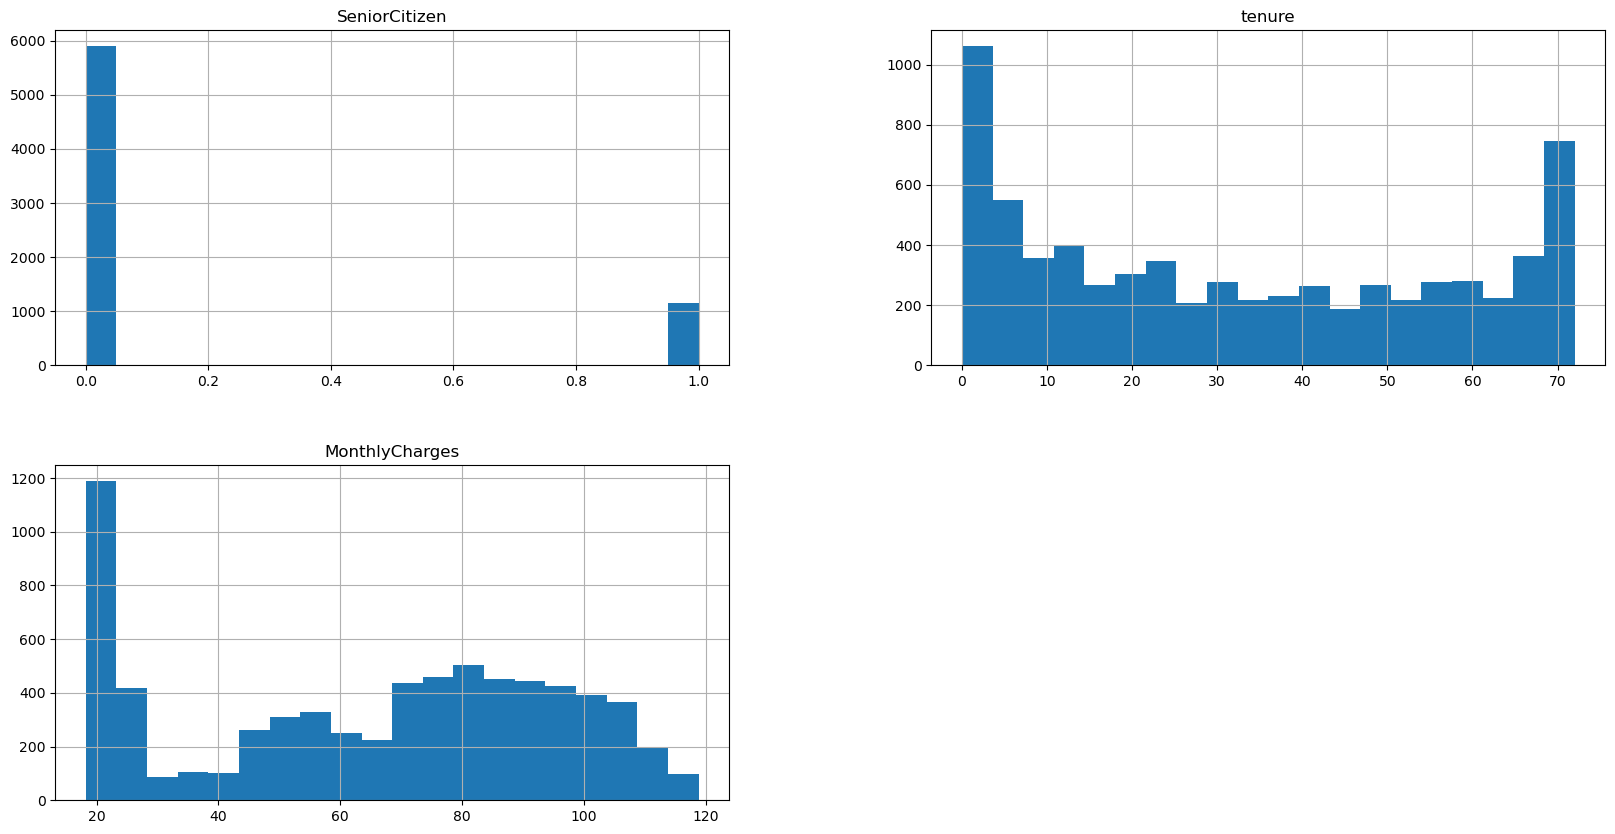

In [6]:
df.hist(bins=20, figsize=(20,10))

This provides a histogram splitting the data into separate buckets, or intervals, then counting the frequency distribution within them. It also provides a nice display of the dispersion of data, but now I want to see how it's distributed around the average values and the degree to which it's distributed around the average (fat, thin, or bell-shaped).

In [ ]:
from xgboost import XGBClassifier